
# Face recognition with Transfer Leraning

In [27]:
import cv2

In [28]:
import numpy as np

In [29]:
from keras.preprocessing import image

In [30]:
from keras.applications import vgg16

In [31]:
img_rows, img_cols=224,224

In [32]:
model=vgg16.VGG16(weights='imagenet', include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

58892288/58889256 [==============================] - 27s 0us/step


In [33]:
model.layers

In [34]:
for (i,layer) in enumerate(model.layers):
    print(str(i)+"  "+model.layers[0].__class__.__name__+"  "+str(model.layers[i].trainable))

0  InputLayer  False
1  InputLayer  True
2  InputLayer  True
3  InputLayer  True
4  InputLayer  True
5  InputLayer  True
6  InputLayer  True
7  InputLayer  True
8  InputLayer  True
9  InputLayer  True
10  InputLayer  True
11  InputLayer  True
12  InputLayer  True
13  InputLayer  True
14  InputLayer  True
15  InputLayer  True
16  InputLayer  True
17  InputLayer  True
18  InputLayer  True


In [35]:
model.layers[0].input

<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>

In [36]:
for layer in model.layers:
    layer.trainable = False

In [37]:
def addToModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 3

FC_Head = addToModel(model, num_classes)

new_model = Model(inputs = model.input, outputs = FC_Head)

print(new_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [42]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'C:/Users/dell/Desktop/mlops/Face recognition with transfer learning/train/'
validation_data_dir = 'C:/Users/dell/Desktop/mlops/Face recognition with transfer learning/validation/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 12
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 3 images belonging to 3 classes.
Found 3 images belonging to 3 classes.


In [46]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("facedetect.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
new_model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 1190
nb_validation_samples = 170
epochs = 3
batch_size = 16

history = new_model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

new_model.save("facedetect.h5")

Epoch 1/3
74/74 [==============================] - 286s 4s/step - loss: 2.9497 - accuracy: 0.8063 - val_loss: 2.0426 - val_accuracy: 0.6667

Epoch 00001: val_loss improved from inf to 2.04263, saving model to facedetect.h5
Epoch 2/3
74/74 [==============================] - 337s 5s/step - loss: 2.9531e-05 - accuracy: 1.0000 - val_loss: 4.0164 - val_accuracy: 0.3333

Epoch 00002: val_loss did not improve from 2.04263
Epoch 3/3
74/74 [==============================] - 323s 4s/step - loss: 0.6300 - accuracy: 0.9730 - val_loss: 2.8146 - val_accuracy: 0.3333

Epoch 00003: val_loss did not improve from 2.04263


In [47]:
train_generator.class_indices

{'DEEPA': 0, 'MOHIT': 1, 'ROHIT': 2}

In [48]:
validation_generator.class_indices

{'DEEPA': 0, 'MOHIT': 1, 'ROHIT': 2}

### TESTING

In [49]:
from keras.models import load_model

In [50]:
m= load_model('facedetect.h5')

In [51]:
from keras.preprocessing import image

In [52]:
timage= image.load_img('C:/Users/dell/Desktop/mlops/Face recognition with transfer learning/test.jpg',target_size=(224,224,3))

In [53]:
type(timage)

PIL.Image.Image

In [54]:
type(timage)

PIL.Image.Image

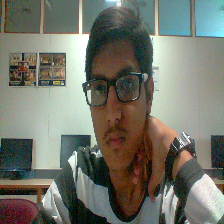

In [55]:
timage

In [56]:
timage= image.img_to_array(timage)

In [57]:
timg= np.expand_dims(timage,axis=0)

In [58]:
timg.shape

(1, 224, 224, 3)

In [59]:
result= m.predict(timg)

In [60]:
result

array([[0., 0., 1.]], dtype=float32)